In [9]:
##Mixture of gaussian
import cv2
import numpy as np
import glob
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from numpy.linalg import inv
import matplotlib.pyplot as plt
import math


#Load Data 
def load_images(file_path):
    imgs_flat = []
    for file in glob.glob(file_path): 
        img = cv2.imread(file)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#       hist = cv2.equalizeHist(gray_img)
        gray = cv2.resize(gray_img,(10,10))
        img_flat = gray.ravel()
        imgs_flat.append(img_flat) 
    return np.array(imgs_flat)

def calculate_gaussian_pdf(data, mu, sig):
	sig_inv = np.linalg.inv(sig)
	det = np.linalg.det(sig)
	temp = data-mu
	term = np.matmul(np.matmul(temp,sig_inv), temp.T)
	exp_term = math.exp(-0.5*term)
	pdf = exp_term/math.sqrt(det) 
	return pdf

## Load Training Data 
positive_train = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Positive\\*.jpg")
negative_train = load_images('H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Training\\Negative\\*.jpg')
##Load Testing Data
test_pos_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Positive\\*.jpg")
test_neg_img = load_images("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Test\\Negative\\*.jpg")

In [21]:
## MoG - EM Algorithm
# data - training data
# N - Number of Gaussian components

def  e_step(m,N, data, mu, sigma,lam):
    for i in range(m):
        for j in range(N):
            l[i, j] = lam[j]*multivariate_normal.pdf(data[i], mu[j], sigma[j])
    l_sum = l.sum(axis=1)
    for i in range(m):
        for j in range(N):
            r[i,j] = l[i,j] / l_sum[i]
    return l,r

def calc_lambda(m,N,r, lam):
    for i in range(N):
        for j in range(m):
            lam[i] += r[j, i]
    lam /= r.sum()
    return lam

def calc_mean(m,N,data,r mu):
    for i in range(N):
        for j in range(m):
            mu[i] += r[j, i] * data[j]
        mu[i] /= r.sum(axis=0)[i]
    return mu

def calc_covariance(m,N,data,r,mu,sigma):
    for i in range(N):
        for j in range(m):
            data_mu_diff = data[j]- mu[i]
            temp = np.reshape(data_mu_diff, (n,1))
            sigma[i] += r[j, i] * np.dot(temp, temp.T)
        sigma[i] /= r.sum(axis=0)[i]
    return sigma
            
def EM(data, N):
    m, n = data.shape
    #Intialize
    l = np.zeros((m,N))
    r = np.zeros((m,N))
    prev_log = -np.inf
    lam = np.empty(N)
    lam.fill(1.0/N)
    mu = np.random.random((N,n))
    sigma = np.ones((N,n,n))*np.cov(data.T)
    
    while True:
            # E-step
            (l,r) = e_step(m,N, data, mu, sigma)
            # M-step
            mu = np.zeros((N, n))
            sigma = np.zeros((N, n, n))
            lam = np.zeros(N)
            
            #Lambda
            lam = calc_lambda(m,N,r, lam) 
            #Mean
            mu = calc_mean(m,N,data,r, mu)
            #Covariance
            sigma = calc_covariance(m,N,data,r,mu,sigma)
            for i in range(N):
                for j in range(m):
                    data_mu_diff = data[j]- mu[i]
                    temp = np.reshape(data_mu_diff, (n,1))
                    sigma[i] += r[j, i] * np.dot(temp, temp.T)
                sigma[i] /= r.sum(axis=0)[i]
            
            current_log = 0.0
            #Log likelihood 
            for i in range(m):
                temp = 0
                for j in range(N):
                    temp += lam[j] * multivariate_normal.pdf(data[i], mu[j], sigma[j])
                current_log += np.log(temp)

            if np.abs(current_log - prev_log) < 0.01:
                break
            print("----")
            print(str(prev_log))
            print(str(current_log))
            prev_log = current_log
    return lam,mu,sigma

In [29]:
##Calculate Predictions
#N - no of gaussian components
#test_data - test_data
def calc_predictions(N, test_data):
    n,m = test_data.shape  
    pred = []
    for data in test_data:
        face = 0
        non_face = 0
        for j in range(N):        
            face_pdf =multivariate_normal.pdf(data, mu_pos[j], sig_pos[j])
            non_face_pdf = multivariate_normal.pdf(data, mu_neg[j], sig_neg[j])
            face_pdf += pi_pos[j]*face_pdf
            non_face_pdf += pi_neg[j]*non_face_pdf
        posterior = face_pdf/(face_pdf + non_face_pdf)
        pred.append(posterior)
    return pred   

In [30]:
##Evaluation of Learned model Performance
def print_result(accuracy, false_postive_rate, false_negative_rate, misclass):
    print("\nResults: ")
    print("----------")
    print("Accuracy: "+str(accuracy))
    print("False positive rate: "+str(false_postive_rate/100))
    print("False negative rate: "+str(false_negative_rate/100))
    print("Misclassification rate: "+str(misclass))
    
def calc_accuracy(probability_pred, original):
    probability_pred = [ round(elem,2) for elem in probability_pred ]
    predictions = []
    for i in probability_pred:
        if i > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    match_count = 0
    for x,y in zip(original, predictions):
        if x==y:
            match_count+=1
    accuracy = match_count/len(predictions)
    misclass = 1-accuracy
    false_postive_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==1:
            false_postive_rate +=1    
    false_negative_rate=0
    for x,y in zip(original, predictions):
        if x!=y & y==0:
            false_negative_rate+=1 
    print_result(accuracy, false_postive_rate, false_negative_rate, misclass)  

    return probability_pred

In [32]:
def mean_visualize(mean, path):
    count = 1
    for f in mean:
        mean_image = np.array(f,dtype="uint8").reshape(10,10)
        mean_image = cv2.resize(mean_image, (60,60))
        cv2.imwrite(path+str(count)+".jpg",mean_image)
        count = count + 1

def cov_visualize(cov, path):
    count = 1
    for f in cov:
        covar_diag = np.rint(np.diag(f))
        covar_diag = np.rint(255 * covar_diag / max(covar_diag))
        covar_array = np.array(covar_diag, dtype='uint8')
        covar_image = covar_array.reshape(10,10)
        covar_image = cv2.resize(covar_image, (60,60))
        cv2.imwrite(path+str(count)+".jpg",covar_image)
        count = count + 1


In [33]:
##Plot ROC curve
def plot_ROC(original, predictions):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(original, predictions)
    roc_auc = roc_auc_score(original,predictions)
    plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='right')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.show()

Model1:
----
-inf
-489449.015435
----
-inf
-431432.389482

Results: 
----------
Accuracy: 0.925
False positive rate: 0.15
False negative rate: 0.0
Misclassification rate: 0.07499999999999996
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.959999

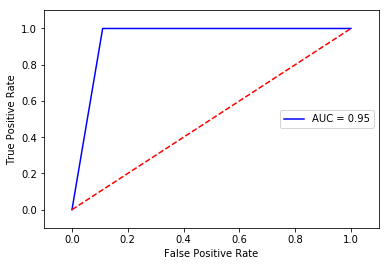

Model3:
----
-inf
-489132.154563
----
-489132.154563
-485258.301735
----
-485258.301735
-481536.856827
----
-481536.856827
-480939.920471
----
-480939.920471
-480882.010197
----
-480882.010197
-480850.755355
----
-480850.755355
-480840.569803
----
-480840.569803
-480840.517961
----
-inf
-428171.671632
----
-428171.671632
-413600.117696
----
-413600.117696
-410547.67584
----
-410547.67584
-408667.998402
----
-408667.998402
-407992.164889
----
-407992.164889
-407595.943679
----
-407595.943679
-407444.383321
----
-407444.383321
-407396.048767
----
-407396.048767
-407341.281795
----
-407341.281795
-407305.515085
----
-407305.515085
-407276.30174
----
-407276.30174
-407249.166117
----
-407249.166117
-407236.848994
----
-407236.848994
-407198.080897


C:\Users\Vidhya\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()



Results: 
----------
Accuracy: 0.78
False positive rate: 0.44
False negative rate: 0.0
Misclassification rate: 0.21999999999999997
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, nan, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.17999999999999999, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.029999999999999999, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,

In [34]:
## Prediction and Evaluation - Test data
original_pos = [1]*100
original_neg = [0]*100
original = original_pos + original_neg
test_data = np.append(test_pos_img,test_neg_img,axis=0)
overall_probability = []
overall_accuracy = []

for i in range(4):
    print("Model"+str(i+1)+":")
    #EM
    (pi_pos,mu_pos,sig_pos) = EM(positive_train,i+1)
    (pi_neg,mu_neg,sig_neg) = EM(negative_train,i+1)
    #Visualization of Mean and Covariance
    mean_visualize(mu_pos, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model2\\"+str(i)+"Comp_mean_pos")
    cov_visualize(sig_pos, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model2\\"+str(i)+"Comp_cov_pos")
    mean_visualize(mu_neg, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model2\\"+str(i)+"Comp_mean_neg")
    cov_visualize(sig_neg, "H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\Model2\\"+str(i)+"Comp_cov_neg")
    #Prediction and Evaluation
    pred_prob = calc_predictions(i+1, test_data)
    (predicted_prob, accuracy) = calc_evaluation_results(pred_prob, original)
    overall_accuracy.append(accuracy)
    overall_probability.append(predicted_prob)
    print (predicted_prob)
    if i == 1:
        predictions = [1 if i > 0.5 else 0 for i in predicted_prob]
        plot_ROC(actual, predictions)
    




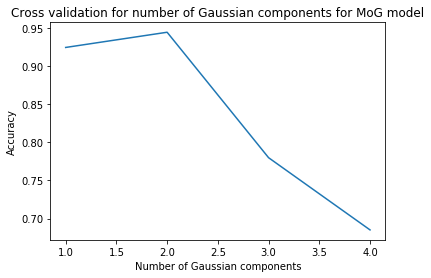

In [35]:
plt.plot([1,2,3,4],overall_accuracy)
 
xlabel('Number of Gaussian components')
ylabel('Accuracy')
title('Cross validation for number of Gaussian components for MoG model')
plt.savefig("H:\\NCSU\\Courses\\Sem2\\CV\\Project\\Output\\cross_validation_graph")
show()